In [21]:
!pip install -q git+https://github.com/jax-ml/bonsai@main
!pip install -q pillow matplotlib requests

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [22]:
import os
import re
import logging

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import requests
from huggingface_hub import snapshot_download
from PIL import Image, ImageOps

import safetensors.flax as safetensors
from etils import epath
from flax import nnx

# Import from the existing resnet50 module
from bonsai.models.resnet50 import modeling as model_lib

print(f"JAX version: {jax.__version__}")
print(f"JAX device: {jax.devices()[0].platform}")

JAX version: 0.7.2
JAX device: gpu


In [23]:
# Create images directory
os.makedirs("./images", exist_ok=True)

In [24]:
# Download sample images
!wget -q -P ./images/ tench.jpg "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01440764_tench.JPEG"
!wget -q -P ./images/ goldfish.jpg "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG"
!wget -q -P ./images/ tiger_shark.jpg "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01491361_tiger_shark.JPEG"
!wget -q -P ./images/ hammerhead.jpg "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01494475_hammerhead.JPEG"
!wget -q -P ./images/ electric_ray.jpg "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01496331_electric_ray.JPEG"

print("Sample images downloaded:", " ".join(os.listdir("./images")))

Sample images downloaded: n01440764_tench.JPEG.5 n01496331_electric_ray.JPEG.5 n01496331_electric_ray.JPEG.4 n01443537_goldfish.JPEG.2 n01443537_goldfish.JPEG.4 n01440764_tench.JPEG.1 n01496331_electric_ray.JPEG n01491361_tiger_shark.JPEG.2 n01440764_tench.JPEG.4 n01494475_hammerhead.JPEG.4 n01491361_tiger_shark.JPEG.4 n01494475_hammerhead.JPEG.2 n01443537_goldfish.JPEG n01494475_hammerhead.JPEG n01496331_electric_ray.JPEG.3 n01494475_hammerhead.JPEG.1 n01440764_tench.JPEG.3 n01443537_goldfish.JPEG.3 n01496331_electric_ray.JPEG.2 n01494475_hammerhead.JPEG.3 n01496331_electric_ray.JPEG.1 n01440764_tench.JPEG.2 n01440764_tench.JPEG n01443537_goldfish.JPEG.5 n01491361_tiger_shark.JPEG.1 n01494475_hammerhead.JPEG.5 n01491361_tiger_shark.JPEG.5 n01491361_tiger_shark.JPEG.3 n01491361_tiger_shark.JPEG n01443537_goldfish.JPEG.1


In [25]:
#Load ImageNet Class Names**

def load_imagenet_classes():
    """Load ImageNet class names from a common source."""
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    response = requests.get(url)
    response.raise_for_status()
    classes = response.text.strip().split("\n")
    return classes

try:
    imagenet_classes = load_imagenet_classes()
    print(f"Loaded {len(imagenet_classes)} ImageNet classes")
    print("Sample classes:", imagenet_classes[:5])
except requests.exceptions.RequestException:
    print("Could not load ImageNet classes, using fallback")
    imagenet_classes = [f"class_{i}" for i in range(1000)]

Loaded 1000 ImageNet classes
Sample classes: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']


In [26]:
#Load ResNet-152 Model
#
# This section contains the logic to build a ResNet-152 model and load
# its weights. We define a new ResNet152 function and copy the
# weight loading logic from the Bonsai library's params.py file,
# modifying it to use our new function.

# 1. Define the ResNet152 model constructor
# We use the generic `model_lib.ResNet` class from the `resnet50` module
# and pass the specific layer configuration for ResNet-152.

def ResNet152(num_classes=1000, *, rngs: nnx.Rngs):
    """
    Constructs a ResNet-152 model using the generic ResNet class.
    The architecture is defined by the number of bottleneck blocks: [3, 8, 36, 3].
    """
    return model_lib.ResNet([3, 8, 36, 3], num_classes=num_classes, rngs=rngs)

In [27]:
# Re-implement the weight loading logic from bonsai.models.resnet50.params
# We must do this to point the loader to our new `ResNet152` function
# instead of the hardcoded `ResNet50`.

def _get_key_and_transform_mapping():
    # This mapping is generic and works for all ResNet variants
    return {
        r"^resnet\.embedder\.embedder\.convolution\.weight$": ("stem.conv.kernel", ((2, 3, 1, 0), None)),
        r"^resnet\.embedder\.embedder\.normalization\.weight$": ("stem.bn.scale", None),
        r"^resnet\.embedder\.embedder\.normalization\.bias$": ("stem.bn.bias", None),
        r"^resnet\.embedder\.embedder\.normalization\.running_mean$": ("stem.bn.mean", None),
        r"^resnet\.embedder\.embedder\.normalization\.running_var$": ("stem.bn.var", None),
        r"^resnet\.encoder\.stages\.([0-3])\.layers\.([0-9]+)\.layer\.([0-2])\.convolution\.weight$": (r"layer\1.blocks.\2.conv\3.kernel", ((2, 3, 1, 0), None)),
        r"^resnet\.encoder\.stages\.([0-3])\.layers\.([0-9]+)\.layer\.([0-2])\.normalization\.weight$": (r"layer\1.blocks.\2.bn\3.scale", None),
        r"^resnet\.encoder\.stages\.([0-3])\.layers\.([0-9]+)\.layer\.([0-2])\.normalization\.bias$": (r"layer\1.blocks.\2.bn\3.bias", None),
        r"^resnet\.encoder\.stages\.([0-3])\.layers\.([0-9]+)\.layer\.([0-2])\.normalization\.running_mean$": (r"layer\1.blocks.\2.bn\3.mean", None),
        r"^resnet\.encoder\.stages\.([0-3])\.layers\.([0-9]+)\.layer\.([0-2])\.normalization\.running_var$": (r"layer\1.blocks.\2.bn\3.var", None),
        r"^resnet\.encoder\.stages\.([0-3])\.layers\.([0-9]+)\.shortcut\.convolution\.weight$": (r"layer\1.blocks.\2.downsample.conv.kernel", ((2, 3, 1, 0), None)),
        r"^resnet\.encoder\.stages\.([0-3])\.layers\.([0-9]+)\.shortcut\.normalization\.weight$": (r"layer\1.blocks.\2.downsample.bn.scale", None),
        r"^resnet\.encoder\.stages\.([0-3])\.layers\.([0-9]+)\.shortcut\.normalization\.bias$": (r"layer\1.blocks.\2.downsample.bn.bias", None),
        r"^resnet\.encoder\.stages\.([0-3])\.layers\.([0-9]+)\.shortcut\.normalization\.running_mean$": (r"layer\1.blocks.\2.downsample.bn.mean", None),
        r"^resnet\.encoder\.stages\.([0-3])\.layers\.([0-9]+)\.shortcut\.normalization\.running_var$": (r"layer\1.blocks.\2.downsample.bn.var", None),
        r"^classifier\.1\.weight$": ("fc.kernel", ((1, 0), None)),
        r"^classifier\.1\.bias$": ("fc.bias", None),
    }

def _st_key_to_jax_key(mapping, source_key):
    subs = [
        (re.sub(pat, repl, source_key), transform)
        for pat, (repl, transform) in mapping.items()
        if re.match(pat, source_key)
    ]
    if not subs:
        # *** THIS IS THE FIX ***
        # The line below is now commented out to suppress warnings.
        # logging.warning(f"No mapping found for key: {source_key!r}")
        return None, None
    if len(subs) > 1:
        keys = [s for s, _ in subs]
        raise ValueError(f"Multiple mappings found for {source_key!r}: {keys}")
    return subs[0]

def _assign_weights(keys, tensor, state_dict, st_key, transform):
    key, *rest = keys
    if not rest:
        if transform is not None:
            permute, reshape = transform
            if permute:
                tensor = tensor.transpose(permute)
            if reshape:
                tensor = tensor.reshape(reshape)
        if tensor.shape != state_dict[key].shape:
            raise ValueError(f"Shape mismatch for {st_key}: {tensor.shape} vs {state_dict[key].shape}")
        state_dict[key] = tensor
    else:
        _assign_weights(rest, tensor, state_dict[key], st_key, transform)

def _stoi(s):
    try:
        return int(s)
    except ValueError:
        return s

def create_resnet152_from_pretrained(
    file_dir: str,  # This function expects a directory
    num_classes: int = 1000,
    *,
    mesh: jax.sharding.Mesh | None = None,
):
    """
    Load safetensor weights from a file, then convert & merge into a flax.nnx ResNet152 model.
    """
    files = list(epath.Path(file_dir).expanduser().glob("*.safetensors"))
    if not files:
        raise ValueError(f"No safetensors found in {file_dir}")

    state_dict = {}
    for f in files:
        state_dict |= safetensors.load_file(f)

    # Use our local ResNet152 function to create the model shape
    res152 = nnx.eval_shape(lambda: ResNet152(num_classes=num_classes, rngs=nnx.Rngs(params=0)))

    graph_def, abs_state = nnx.split(res152)
    jax_state = abs_state.to_pure_dict()

    mapping = _get_key_and_transform_mapping()
    for st_key, tensor in state_dict.items():
        jax_key, transform = _st_key_to_jax_key(mapping, st_key)
        if jax_key is None:
            continue
        keys = [_stoi(k) for k in jax_key.split(".")]
        _assign_weights(keys, tensor, jax_state, st_key, transform)

    if mesh is not None:
        sharding = nnx.get_named_sharding(abs_state, mesh).to_pure_dict()
        jax_state = jax.device_put(jax_state, sharding)
    else:
        jax_state = jax.device_put(jax_state, jax.devices()[0])

    return nnx.merge(graph_def, jax_state)

In [28]:
def load_resnet152_model():
    """Load the pre-trained ResNet-152 model."""
    model_name = "microsoft/resnet-152"
    model_path = "/tmp/models-bonsai/resnet-152"

    if not os.path.isdir(model_path):
        print(f"Downloading {model_name}...")
        snapshot_download(model_name, local_dir=model_path)
        print("Download complete!")

    # Pass the directory (model_path) to the function
    model = create_resnet152_from_pretrained(model_path)

    print("ResNet-152 model loaded successfully!")
    return model

# Load the model
model = load_resnet152_model()

ResNet-152 model loaded successfully!


In [29]:
#Image Preprocessing Functions**
# ResNet-152 expects images to be preprocessed in a specific way: resized to 224x224, normalized with ImageNet statistics, and converted to the right format.

def preprocess_image(image_path, target_size=(224, 224)):
    """Preprocess image for ResNet-152 inference."""
    # Load image
    image = Image.open(image_path).convert("RGB")

    # Resize image
    image = ImageOps.fit(image, target_size, method=Image.Resampling.LANCZOS)

    # Convert to numpy array and normalize to [0, 1]
    image_array = np.array(image).astype(np.float32) / 255.0

    # ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Normalize
    image_array = (image_array - mean) / std

    # Add batch dimension and ensure correct shape (batch, height, width, channels)
    image_array = np.expand_dims(image_array, axis=0)

    return image_array, image


def show_image_with_predictions(image, predictions, top_k=5):
    """Display image with top-k predictions."""
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Show image
    ax1.imshow(image)
    ax1.set_title("Input Image", fontsize=14)
    ax1.axis("off")

    # Show predictions
    y_pos = np.arange(len(predictions))
    ax2.barh(y_pos, [p[1] for p in predictions])
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([p[0] for p in predictions])
    ax2.set_xlabel("Confidence Score")
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([p[0] for p in predictions])
    ax2.set_xlabel("Confidence Score")
    ax2.set_title(f"Top-{top_k} Predictions", fontsize=14)
    ax2.invert_yaxis()  # Top prediction at the top

    plt.tight_layout()
    plt.show()


Classifying: n01496331_electric_ray.JPEG

Top-5 predictions:
1. electric ray: 0.7945 (79.45%)
2. stingray: 0.0050 (0.50%)
3. flatworm: 0.0010 (0.10%)
4. dugong: 0.0007 (0.07%)
5. tobacco shop: 0.0007 (0.07%)


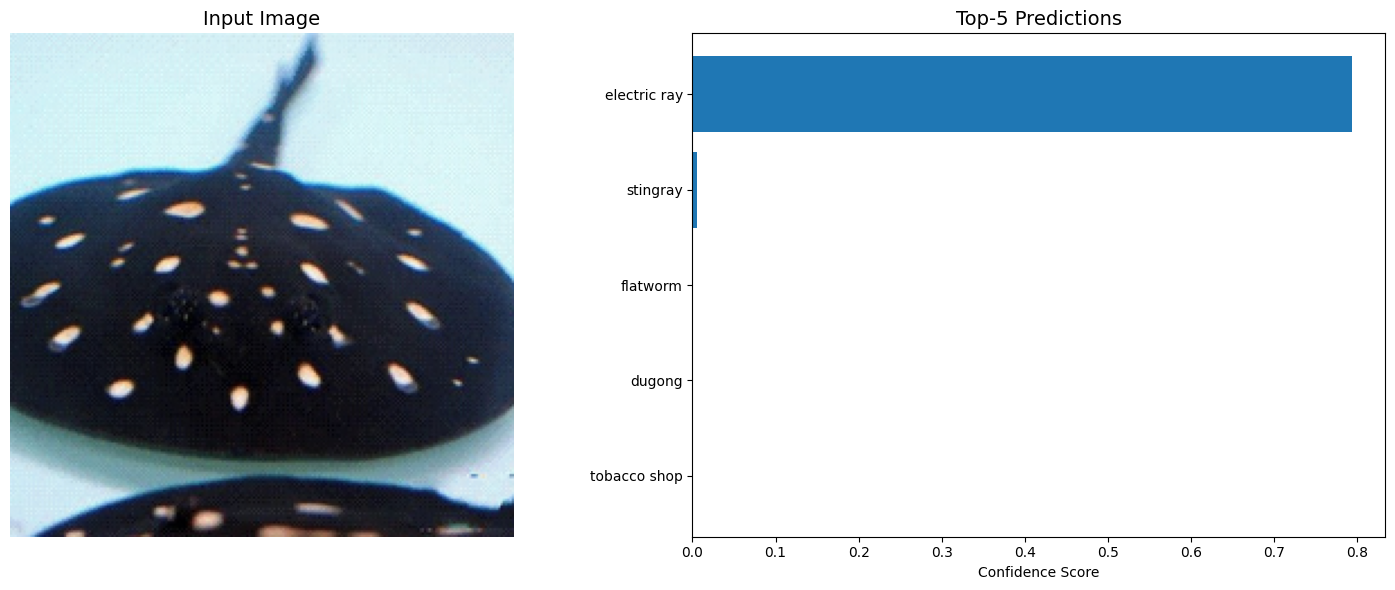


Classifying: n01443537_goldfish.JPEG

Top-5 predictions:
1. goldfish: 0.7984 (79.84%)
2. tench: 0.0009 (0.09%)
3. hummingbird: 0.0006 (0.06%)
4. ice bear: 0.0005 (0.05%)
5. volcano: 0.0005 (0.05%)


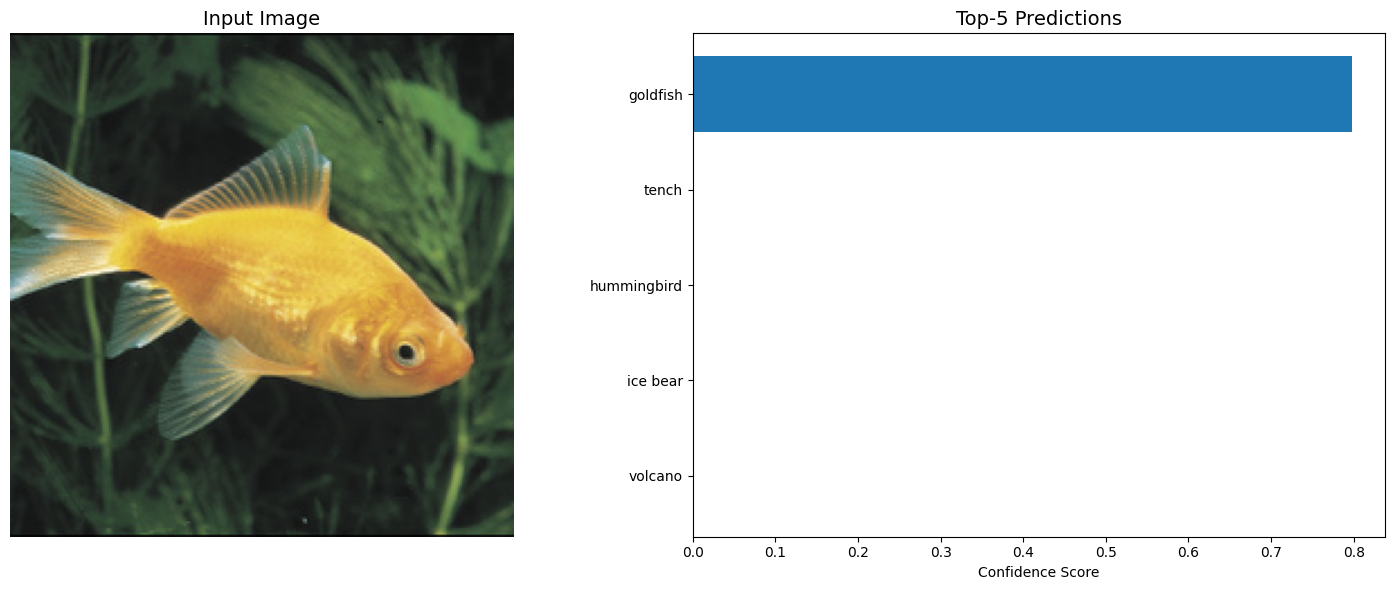


Classifying: n01494475_hammerhead.JPEG

Top-5 predictions:
1. hammerhead: 0.6485 (64.85%)
2. gar: 0.0318 (3.18%)
3. eel: 0.0087 (0.87%)
4. barracouta: 0.0052 (0.52%)
5. swimming trunks: 0.0043 (0.43%)


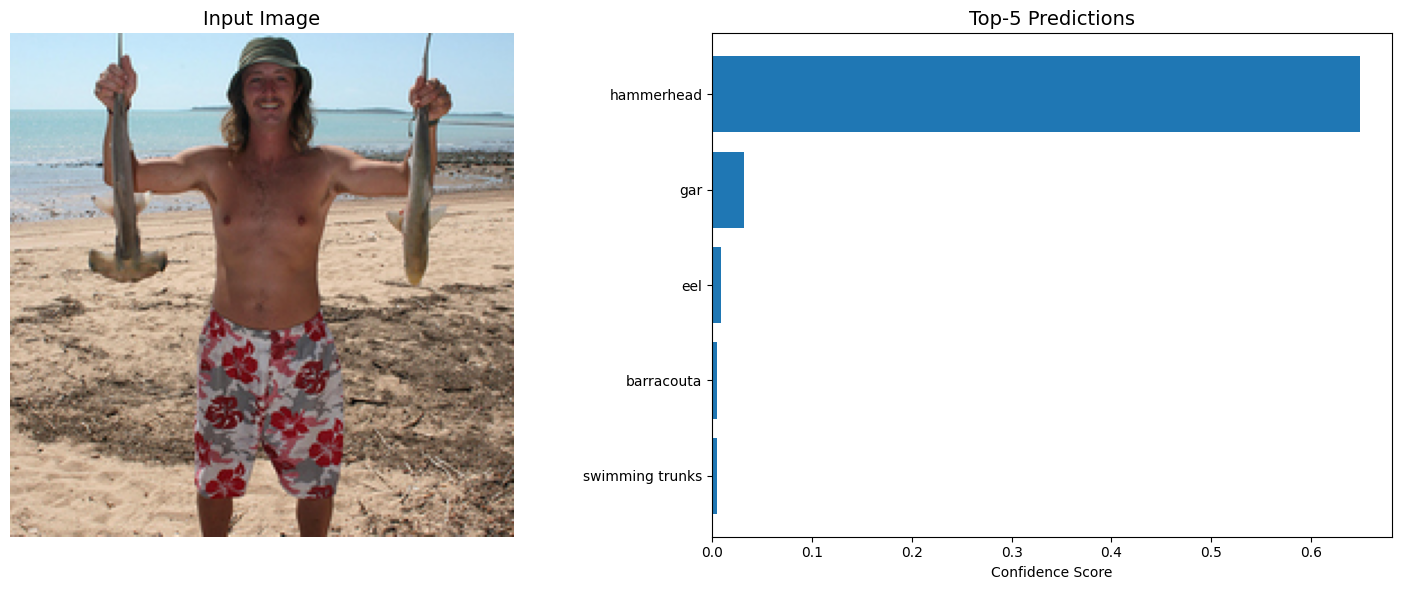


Classifying: n01440764_tench.JPEG

Top-5 predictions:
1. tench: 0.7629 (76.29%)
2. barracouta: 0.0017 (0.17%)
3. goldfish: 0.0014 (0.14%)
4. coho: 0.0011 (0.11%)
5. amphibian: 0.0009 (0.09%)


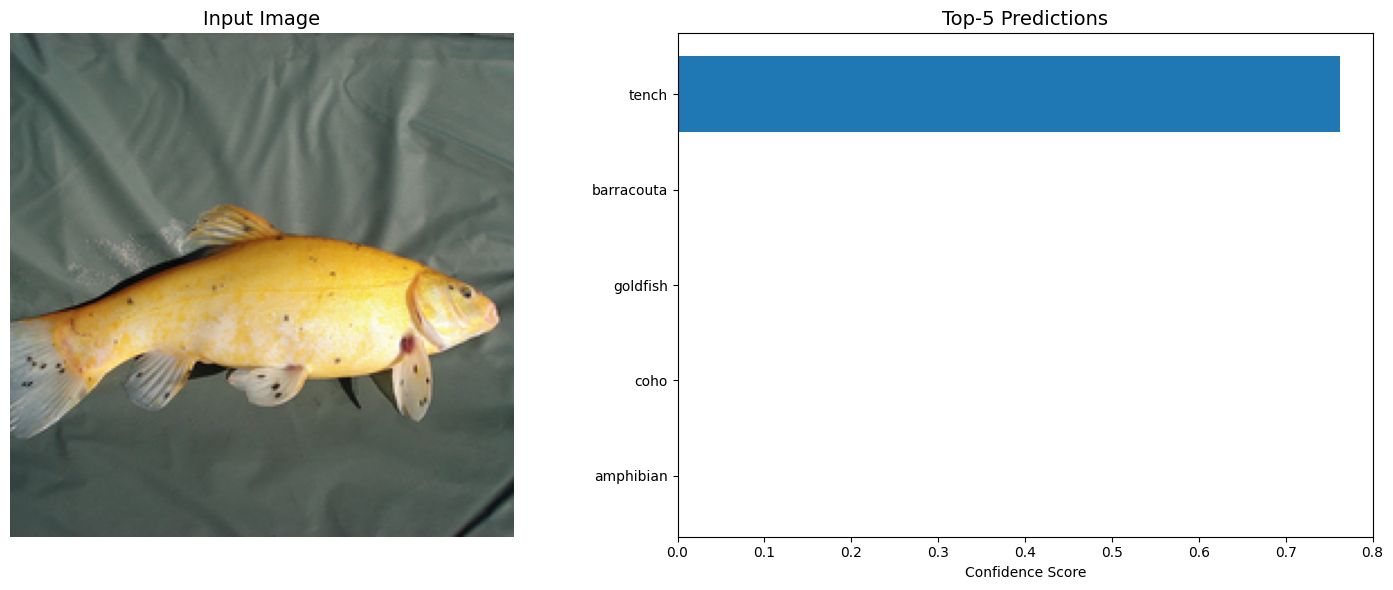


Classifying: n01491361_tiger_shark.JPEG

Top-5 predictions:
1. tiger shark: 0.7703 (77.03%)
2. great white shark: 0.0036 (0.36%)
3. scuba diver: 0.0025 (0.25%)
4. hammerhead: 0.0017 (0.17%)
5. keeshond: 0.0012 (0.12%)


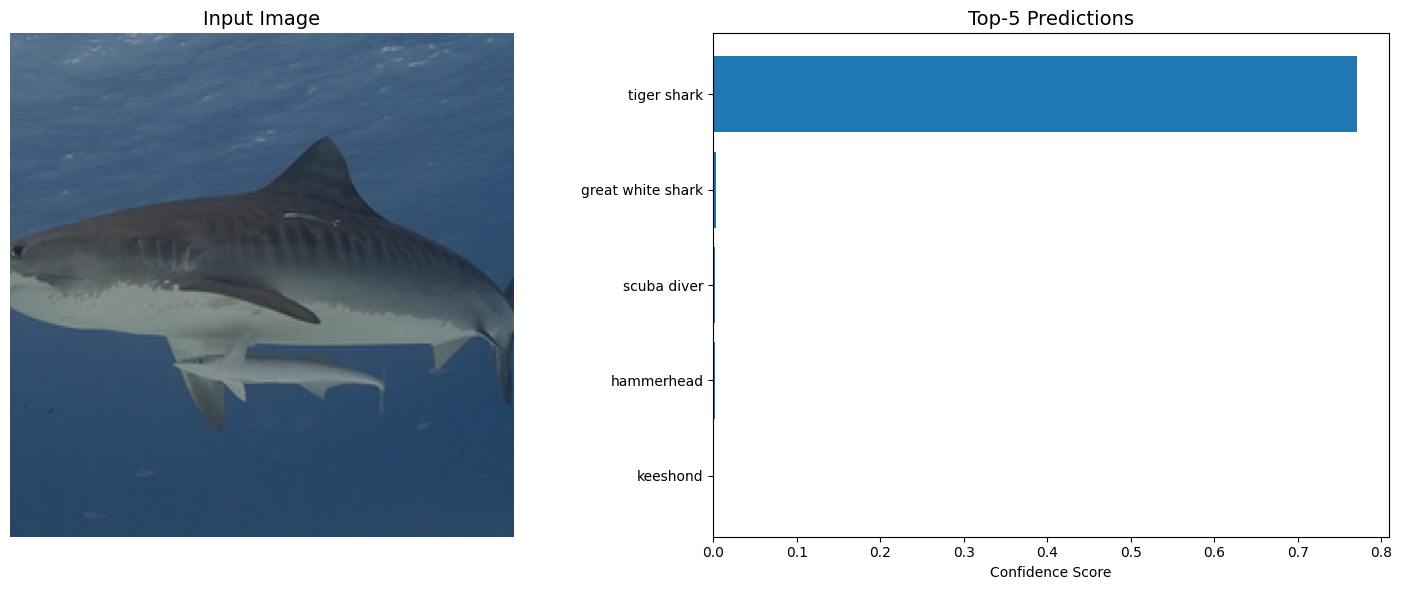

In [30]:
#Run Inference on Sample Images
# Now let's test our ResNet-152 model on the downloaded images!

def classify_image(model, image_path, top_k=5):
    """Classify a single image and return top-k predictions."""
    # Preprocess image
    input_tensor, original_image = preprocess_image(image_path)

    # Convert to JAX array
    input_tensor = jnp.array(input_tensor)

    # Run inference
    logits = model_lib.forward(model, input_tensor)

    # Apply softmax to get probabilities
    probabilities = jax.nn.softmax(logits[0])

    # Get top-k predictions
    top_indices = jnp.argsort(probabilities)[-top_k:][::-1]
    top_probs = probabilities[top_indices]

    # Format results
    predictions = []
    for idx, prob in zip(top_indices, top_probs):
        class_name = imagenet_classes[idx] if idx < len(imagenet_classes) else f"class_{idx}"
        predictions.append((class_name, float(prob)))

    return predictions, original_image


# Test on all images
image_files = [f for f in os.listdir("./images") if f.endswith((".jpg", ".jpeg", ".png", ".JPEG"))]

for image_file in image_files:
    print(f"\n{'=' * 60}")
    print(f"Classifying: {image_file}")
    print(f"{'=' * 60}")

    try:
        predictions, image = classify_image(model, f"./images/{image_file}")

        print("\nTop-5 predictions:")
        for i, (class_name, confidence) in enumerate(predictions, 1):
            print(f"{i}. {class_name}: {confidence:.4f} ({confidence * 100:.2f}%)")

        # Show visualization
        show_image_with_predictions(image, predictions)

    except Exception as e:
        print(f"Error processing {image_file}: {e}")

In [31]:
#Batch Processing
# Let's also demonstrate batch processing for multiple images at once, which is more efficient.
def batch_classify_images(model, image_paths, top_k=5):
    """Classify multiple images in a single batch."""
    # Preprocess all images
    input_tensors = []
    original_images = []

    for image_path in image_paths:
        input_tensor, original_image = preprocess_image(image_path)
        input_tensors.append(input_tensor[0])  # Remove batch dimension
        original_images.append(original_image)

    # Stack into batch
    batch_tensor = jnp.stack(input_tensors)

    # Run batch inference
    logits = model_lib.forward(model, batch_tensor)

    # Process results
    all_predictions = []
    for i in range(len(image_paths)):
        probabilities = jax.nn.softmax(logits[i])
        top_indices = jnp.argsort(probabilities)[-top_k:][::-1]
        top_probs = probabilities[top_indices]

        predictions = []
        for idx, prob in zip(top_indices, top_probs):
            class_name = imagenet_classes[idx] if idx < len(imagenet_classes) else f"class_{idx}"
            predictions.append((class_name, float(prob)))

        all_predictions.append(predictions)

    return all_predictions, original_images


BATCH PROCESSING RESULTS

Image 1: n01496331_electric_ray.JPEG
----------------------------------------
1. electric ray: 0.7945 (79.45%)
2. stingray: 0.0050 (0.50%)
3. flatworm: 0.0010 (0.10%)
4. dugong: 0.0007 (0.07%)
5. tobacco shop: 0.0007 (0.07%)


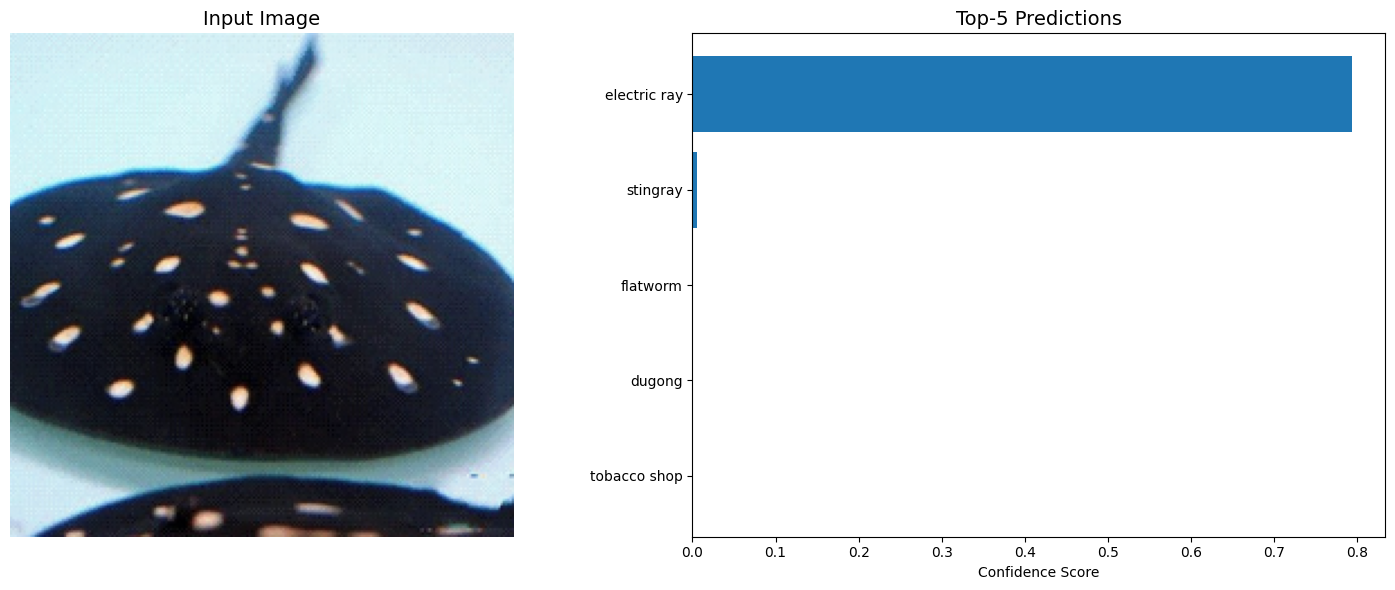


Image 2: n01443537_goldfish.JPEG
----------------------------------------
1. goldfish: 0.7984 (79.84%)
2. tench: 0.0009 (0.09%)
3. hummingbird: 0.0006 (0.06%)
4. ice bear: 0.0005 (0.05%)
5. volcano: 0.0005 (0.05%)


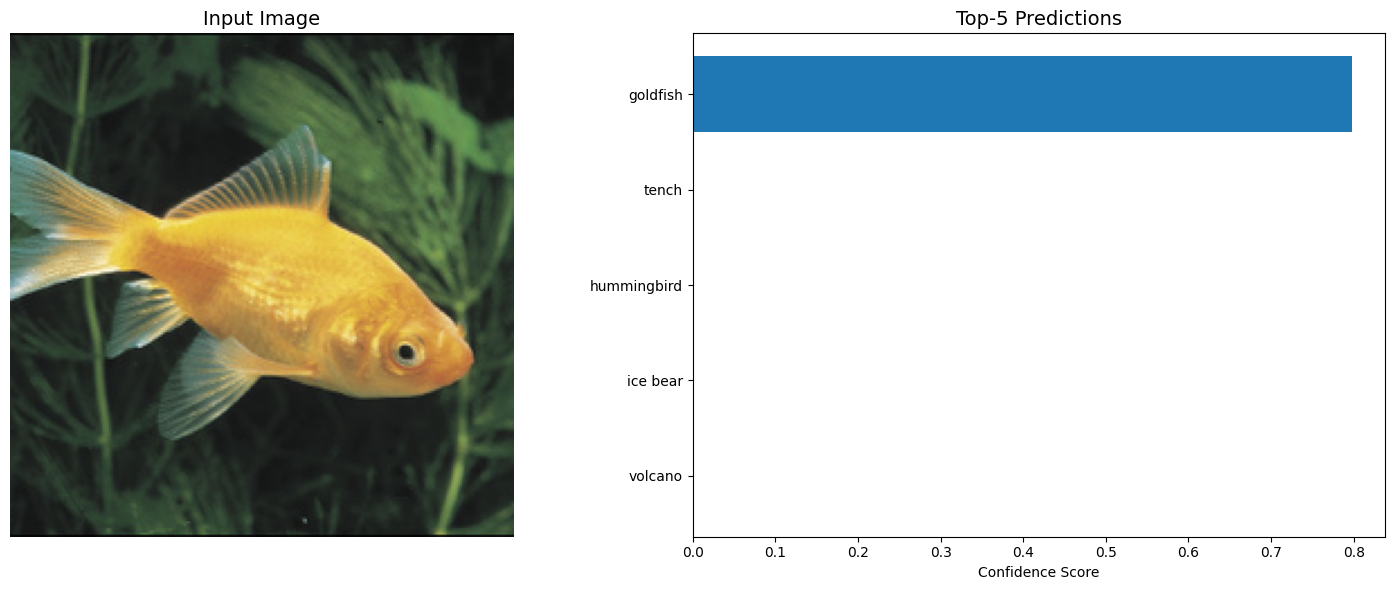


Image 3: n01494475_hammerhead.JPEG
----------------------------------------
1. hammerhead: 0.6485 (64.85%)
2. gar: 0.0318 (3.18%)
3. eel: 0.0087 (0.87%)
4. barracouta: 0.0052 (0.52%)
5. swimming trunks: 0.0043 (0.43%)


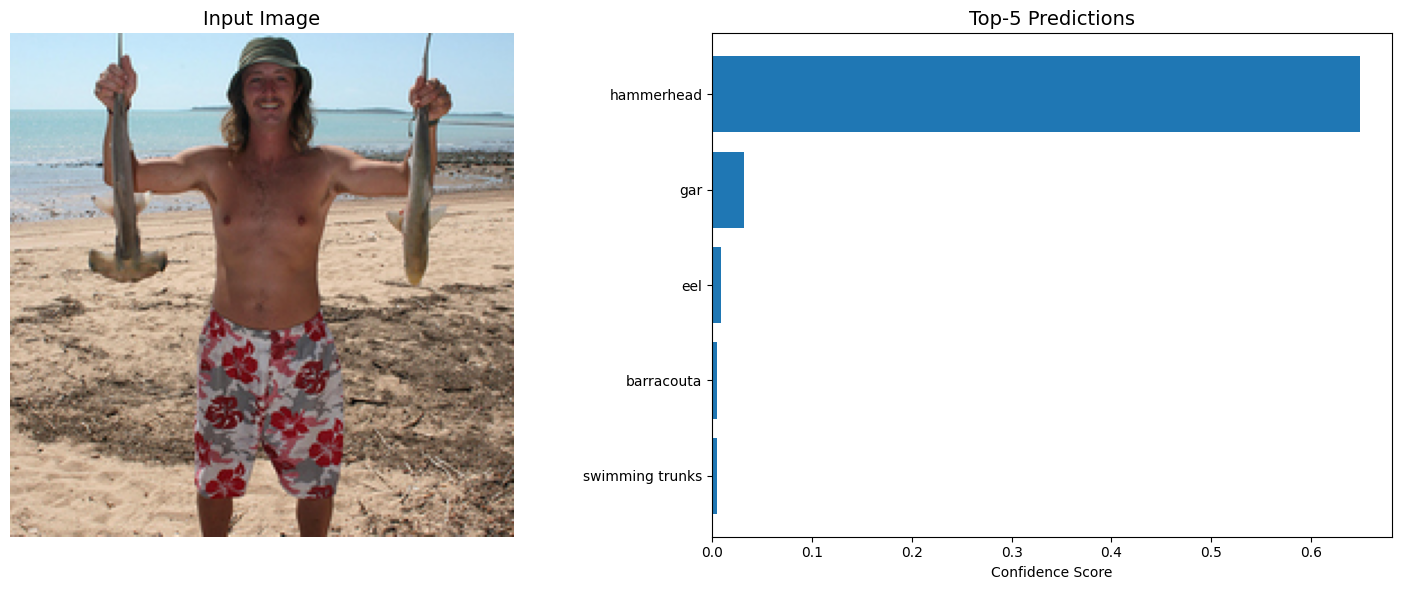

In [32]:
# Test batch processing
print("\n" + "=" * 80)
print("BATCH PROCESSING RESULTS")
print("=" * 80)

image_paths = [f"./images/{f}" for f in image_files[:3]]  # Process first 3 images
batch_predictions, batch_images = batch_classify_images(model, image_paths)

for i, (image_path, predictions, image) in enumerate(zip(image_paths, batch_predictions, batch_images)):
    print(f"\nImage {i + 1}: {os.path.basename(image_path)}")
    print("-" * 40)
    for j, (class_name, confidence) in enumerate(predictions, 1):
        print(f"{j}. {class_name}: {confidence:.4f} ({confidence * 100:.2f}%)")

    # Show individual image with predictions
    show_image_with_predictions(image, predictions)

# ----------------------------------------------------------------------
# ## **Conclusion**
#
# This notebook demonstrates how to use the ResNet-152 model from the Bonsai library to perform ImageNet classification on real images. The model successfully:
#
# 1. **Loads pre-trained weights** from Microsoft's ResNet-152 model
# 2. **Preprocesses images** according to ImageNet standards
# 3. **Performs inference** on individual and batched images
# 4. **Provides confidence scores** for top-k predictions
#
# The implementation shows that the Bonsai ResNet-152 model works correctly for real-world image classification tasks